This notebook was used to creat our FRB population and Figure 1 of the paper.

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd

from mockFRBhosts import generate_frbs, plot_population

In [2]:
# Compare the luminosity values obtained from different papers.
# Energy from Shin et al. 2022 also in a 1GHz band, but probably at 600MHz
print(10**41.29/(1e9*0.001))  # 1GHz bandwidth mean at CHIME is ~1ms
print(np.log10(10**41.29/(1e9*0.001)*(1.3/0.6)**(-.65)))  # shift it to 1.3 GHz
print(10**41.76/(1e9*0.001)*(1.3/0.6)**(-.65))  # shift it to 1.3 GHz
print(10**40.83/(1e9*0.001)*(1.3/0.6)**(-.65))  # shift it to 1.3 GHz
print(10**41.40/(1e9*0.00549))  # James plus their width mu
print(10**41.40/(1e9*0.00267))  # James plus Arcus width mu
E_James = np.log10(10**41.88/(1e9*0.00267))
print(E_James)  # James with uniform prior plus Arcus width mu
print(np.log10(10**(41.88+.24)/(1e9*0.00267))-E_James)  # James with uniform prior plus Arcus width mu
print(np.log10(10**(41.88-.48)/(1e9*0.00267))-E_James)  # James with uniform prior plus Arcus width mu
# Hashimoto
print(np.log10(1e33*(1.3/1.83)**-.65/(2.8e-3)))

1.9498445997580413e+35
35.071735133749925
3.481249368606615e+35
4.090111371310695e+34
4.575385121146761e+34
9.407814350223115e+34
35.45348873863543
0.240000000000002
-0.4799999999999969
35.64937199798312


In [3]:
# Define the telescope and FRB population parameters that are not kept constant.
# Uncomment the survey and distance distribution that you want to generate.
# Pick z_max and bol_lum_low such that they do not limit the distribution 
# but still yield enough observed FRBs. You might wanna pick higher bol_lum_low
# values as I probably overdid it a bit.
# ASKAP
survey_model, beam_model = 'askap-incoh', 'gaussian'
z_model, z_max, bol_lum_low = 'sfr', 1.2, 2e40       # Available: 'vol_co', 'sfr', 'smd'
# z_model, z_max, bol_lum_low = 'smd', 1.2, 8e39
# z_model, z_max, bol_lum_low = 'vol_co', 1.2, 5e39

# ASKAP-CRACO
# survey_model, beam_model = 'askap-incoh', 'gaussian'
# survey = Survey(survey_model)
# survey.gain *= 4.4
# survey.bw = 288
# survey_model = survey
# z_model, z_max, bol_lum_low = 'sfr', 2.5, 8e39
# z_model, z_max, bol_lum_low = 'smd', 1.8, 2e39
# z_model, z_max, bol_lum_low = 'vol_co', 2., 3e39

# chord
# survey_model, beam_model = 'chord', 'chime-frb'
# z_model, z_max, bol_lum_low = 'sfr', 4.5, 1e41
#z_model, z_max, bol_lum_low = 'smd', 4., 1e40
#z_model, z_max, bol_lum_low = 'vol_co', 5., 5e40

# Meerkat (values in frbpoppy seem to be placeholders)
#survey_model, beam_model = 'meerkat', 'gaussian'
#z_model, z_max, bol_lum_low = 'sfr', 1.5, 1e40
#z_model, z_max, bol_lum_low = 'smd', 1.5, 1e40
#z_model, z_max, bol_lum_low = 'vol_co', 2., 1e40

# SKA1-mid
# survey_model, beam_model = 'ska1-mid', 'gaussian'
# z_model, z_max, bol_lum_low = 'sfr', 6., 3e37
#z_model, z_max, bol_lum_low = 'smd', 5., 4e36
#z_model, z_max, bol_lum_low = 'vol_co', 6., 3e37

# CHIME
# survey_model, beam_model = 'chime-frb', 'chime-frb'
# z_model, z_max, bol_lum_low = 'sfr', 3.5, 1e41
# z_model, z_max, bol_lum_low = 'smd', 2.2, 1e40
# z_model, z_max, bol_lum_low = 'vol_co', 2.8, 3e40

In [4]:
# Use these instead of the previous cell if you want to loop over several populations.
# Also uncomment the loop below
all_runs = [
    # # ASKAP
    # ['askap-incoh', 'gaussian', 'sfr', 1.2, 2e40],
    # ['askap-incoh', 'gaussian', 'smd', 1.2, 8e39],
    # ['askap-incoh', 'gaussian', 'vol_co', 1.2, 5e39],
    # # CHIME
    # ['chime-frb', 'chime-frb', 'sfr', 3.5, 1e41],
    # ['chime-frb', 'chime-frb', 'smd', 2.2, 1e40],
    # ['chime-frb', 'chime-frb', 'vol_co', 2.8, 3e40],
    # # Meerkat
    # ['meerkat', 'gaussian', 'sfr', 1., 1e40],
    # ['meerkat', 'gaussian', 'smd', 1.2, 5e39],
    # ['meerkat', 'gaussian', 'vol_co', 1.2, 1e40],
    # # SKA1-mid
    # ['ska1-mid', 'gaussian', 'sfr', 6., 3e37],
    # ['ska1-mid', 'gaussian', 'smd', 5., 4e36],
    # ['ska1-mid', 'gaussian', 'vol_co', 6., 3e37],
]

cosmic_pop.py | Generating cosmic population
cosmic_pop.py | Finished generating cosmic population
survey_pop.py | Surveying cosmic with askap-incoh
56 FRBs have been observed
1195 FRBs will be saved


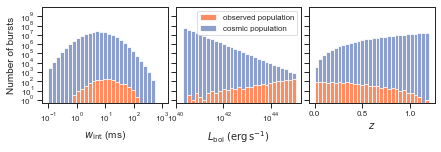

In [5]:
n_frbs = 1000

# Uncomment the following line and indent everything below if you want to loop over "all_runs".
# for survey_model, beam_model, z_model, z_max, bol_lum_low in all_runs:

# Define the names of files to be saved. Consider the special cases of CRACO.
if isinstance(survey_model, str):
    file = f"../Simulated_FRBs/{survey_model}_{z_model}.pickle"
    fig_name = f"../Simulated_FRBs/{survey_model}_{z_model}.png"
else:
    file = f"../Simulated_FRBs/askap-craco_{z_model}.pickle"
    fig_name = f"../Simulated_FRBs/askap-craco_{z_model}.png"

# Make a new file if non-existend pickle file
if os.path.isfile(file):
    frbs = np.load(file, allow_pickle=True)
else:
    frbs = pd.DataFrame()
    print("Starting a new FRB population")

i = 0
while (frbs.shape[0] < n_frbs and i < 100) or i == 0:
    try:
        # Free workspace. Somehow this is not done automatically.
        del(cosmic_pop)
        gc.collect()
    except:
        pass
    energy_high = 10**41.88  # James et al. 2022 with alpha as rate but with uniform prior
    specif_lum_high = energy_high/(1e9*0.00267)  # 1GHz bandwidth 2.67ms
    cosmic_pop, survey_pop = generate_frbs(survey_model, beam_model, z_model=z_model, n_srcs=1e7, z_max=z_max, 
                                           bol_lum_low=bol_lum_low, specif_lum_high=specif_lum_high)
    frbs = frbs.append(survey_pop.to_df())
    print(survey_pop.n_bursts(), "FRBs have been observed")
    i += 1
    # Uncomment the following and the last line if the code is run on a laptop.
    # if i == 33 or i == 66:  
    #     time.sleep(60*10)

print(frbs.shape[0], "FRBs will be saved")
frbs.to_pickle(file)

fig = plot_population(frbs, cosmic_pop, cpop_factor=n_frbs//survey_pop.n_bursts(), plot_james=False)

# fig.savefig(fig_name, dpi=300, bbox_inches='tight')
fig.show()
#time.sleep(60*20)  # 20 minutes break to prevent overheating